In [1]:
from sklearn.datasets import make_blobs
from sklearn.manifold import MDS

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sys

import umap

import distinctipy

from bokeh.plotting import figure, show, save, output_file
from bokeh.models import HoverTool, TabPanel, Tabs

sys.path.append('../../')
from utils import clustering_utils, rna_seq_utils, bokeh_ui_utils, microarray_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
# X, y = make_blobs(n_samples=10000, centers=3, n_features=10, random_state=0)
# print(X.shape)

# X_dist = clustering_utils.compute_pairwise_distance_matrix(X, 'manhattan')

# mds_mapper = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', n_jobs=-1)
# embedding = mds_mapper.fit_transform(X_dist)

# umap_df = pd.DataFrame(np.array(embedding), columns=('x', 'y'))

# plt.scatter(umap_df['x'], umap_df['y'])

In [3]:
def rgb_to_hex(rgb):
    """
    Convert RGB tuple to hexadecimal color code.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

In [4]:
def generate_embedding_plot(embedding_df, colors_dict, title=''):
    bokeh_x = 'x'
    bokeh_y = 'y'
    color_column = 'label' 

    # axis_padding = 0.05
    # x_min, x_max = embedding_df[bokeh_x].min() - axis_padding * embedding_df[bokeh_x].min(), embedding_df[bokeh_x].max() + axis_padding * embedding_df[bokeh_x].max()
    # y_min, y_max = embedding_df[bokeh_y].min() - axis_padding * embedding_df[bokeh_y].min(), embedding_df[bokeh_y].max() + axis_padding * embedding_df[bokeh_y].max()

    p = figure(title=title, sizing_mode='stretch_both',
                # x_range=(x_min, x_max), 
                # y_range=(y_min, y_max),
                )

    for val in sorted(embedding_df[color_column].unique()):
        col_df=embedding_df.loc[(embedding_df[color_column]==val)]
        p.scatter(bokeh_x, bokeh_y, 
                    # size=bokeh_ui_utils.compute_2d_embedding_point_radius(embedding_df, const=3), 
                    size=3,
                    color=colors_dict[val], 
                    # legend_label=val, 
                source=col_df)

    tooltips = []
    for column in col_df.columns[col_df.shape[1] - 1:]:
        tooltip = (column.replace('_', ' ').title(), f'@{column}')
        tooltips.append(tooltip)

    hover = HoverTool(tooltips=tooltips)

    p.add_tools(hover)

    # p.legend.click_policy="hide"
    # p.legend.location = "bottom_left"

    p.xaxis.axis_label = bokeh_x
    p.yaxis.axis_label = bokeh_y

    p.min_border = 100

    return p

In [5]:
def avg_nexpr_per_mod(full_filtered_norm_df: pd.DataFrame, leiden_label_df_round_1_arranged_sorted: pd.DataFrame):    
    avg_df = None

    for m in leiden_label_df_round_1_arranged_sorted['label'].unique():

        curr_df = (full_filtered_norm_df.loc[full_filtered_norm_df['TTHERM_ID'].isin(
                        (leiden_label_df_round_1_arranged_sorted.loc[leiden_label_df_round_1_arranged_sorted['label'] == m]['TTHERM_ID'].values)
                    )].iloc[:, 1:].mean()).to_frame().T
        curr_df['label'] = m

        if avg_df is None:
            avg_df = curr_df
            continue

        avg_df = pd.concat((avg_df, curr_df), ignore_index=True)

    avg_df = avg_df.loc[: , list(avg_df.columns)[avg_df.shape[1] - 1:] + list(avg_df.columns)[0: avg_df.shape[1] - 1]]

    return avg_df

In [6]:
DATASET = 'microarray'
# DATASET = 'rna_seq'

In [7]:
if DATASET == 'rna_seq':
    full_filtered_df = pd.read_csv('../../active_fastas/rna_seq.csv')
    full_filtered_norm_df = rna_seq_utils.normalize_expression_per_gene(full_filtered_df)

    leiden_label_df_round_1_arranged_sorted = pd.read_csv('./rna_seq_label_df_round_1.csv')

    mds_file = './rna_seq_mds.csv'
    nmds_file = './rna_seq_nmds.csv'

elif DATASET == 'microarray':
    full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
    full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
    full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)

    leiden_label_df_round_1_arranged_sorted = pd.read_csv('./test_nn3_leiden_label_df_round_1.csv')

    mds_file = './microarray_mds.csv'
    nmds_file = './microarray_nmds.csv'

In [8]:
mds_embeddind_df = pd.read_csv(mds_file)
mds_embeddind_df['TTHERM_ID'] = full_filtered_norm_df['TTHERM_ID'].values
mds_embeddind_df = mds_embeddind_df.merge(leiden_label_df_round_1_arranged_sorted, on='TTHERM_ID', how='inner')

nmds_embeddind_df = pd.read_csv(nmds_file)
nmds_embeddind_df['TTHERM_ID'] = full_filtered_norm_df['TTHERM_ID'].values
nmds_embeddind_df = nmds_embeddind_df.merge(leiden_label_df_round_1_arranged_sorted, on='TTHERM_ID', how='inner')

In [9]:
leiden_label_df_round_1_arranged_sorted.sample(10)

,TTHERM_ID,label
3428,YF00024246.t1,468
15371,YF00008104.t1,116
8785,YF00015221.t1,312
15206,YF00015023.t1,121
11721,YF00004191.t1,235
4939,YF00021111.t1,428
16207,YF00008851.t1,92
45,YF00021504.t1,562
11674,YF00008319.t1,236
16752,YF00023332.t1,75


In [10]:
full_filtered_norm_df.sample(10)

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
12336,YF00020948.t1,1.128412,2.140066,1.754084,1.002953,1.601203,1.522738,0.895115,1.844039,1.768037,...,-0.860590,0.651260,0.332013,0.499336,-0.908676,-0.092129,-1.286316,-0.121865,-0.423444,-1.053074
15958,YF00027134.t1,-0.568254,0.014144,0.193747,-1.394626,-0.358170,0.111028,-1.491070,0.004561,-0.002627,...,1.526854,0.868785,0.903227,1.558051,-0.116716,0.224264,0.526586,-0.100455,0.264506,0.898250
2892,YF00004816.t1,-1.311642,-3.044346,-1.773557,-0.429306,-1.179662,-0.539150,0.249888,0.151053,0.655258,...,0.580936,0.961876,0.879743,0.440587,0.554112,0.582165,-0.231817,-0.307000,-0.021541,-0.433047
11659,YF00019947.t1,0.842291,1.394433,1.417164,1.518858,1.482874,2.617212,0.196837,1.392307,1.829437,...,-0.328755,-0.317933,0.005450,-0.875257,0.397737,-0.285655,0.105229,0.150933,-0.655847,-0.535424
881,YF00001351.t1,-1.160870,-1.267367,-1.254155,-0.611541,-0.857218,-1.822162,-1.287596,-1.311518,-1.371319,...,-1.158508,0.669951,0.071994,1.241604,0.992512,0.004279,1.045953,1.134006,0.280985,0.549681
15190,YF00025740.t1,-0.323257,-0.254977,-0.312025,-0.228057,-0.088351,0.583291,-0.165595,-0.655661,0.122287,...,-0.433760,-0.250982,-0.593937,-0.710762,-0.314553,-0.743397,0.404993,-0.151915,-0.444378,-0.329999
9304,YF00016207.t1,-0.065357,-0.650408,-0.407055,-0.916960,-0.659183,0.739382,-0.470424,-0.547959,-1.006188,...,-0.416643,-0.878316,-0.961952,-1.230031,-0.081584,-0.417246,-0.444094,0.018701,0.766631,-0.512128
11518,YF00019705.t1,1.476901,1.101976,0.912472,0.419819,1.635273,1.068038,-0.434573,1.069330,0.653254,...,-1.802242,-0.271718,-0.285915,-0.995776,1.119884,0.209003,0.015250,0.773084,0.209908,-0.449187
7903,YF00013694.t1,-1.032515,-1.639639,-0.131025,0.214697,-0.912355,-0.410651,0.714662,0.166353,0.200537,...,-0.465425,-1.201190,-0.472212,-0.651510,-0.668335,-0.648053,-1.224139,-1.028887,-0.720754,-0.225587
3183,YF00005266.t1,-1.853300,-1.559364,-1.341535,-1.484620,-0.665473,-1.293838,-2.177168,-0.814872,-0.351440,...,0.551894,0.505656,0.637819,0.480059,0.719328,0.569606,0.497187,0.786496,0.601891,0.871618


In [11]:
leiden_label_df_round_1_arranged_sorted.loc[leiden_label_df_round_1_arranged_sorted['label'] == 24]['TTHERM_ID'].values

array(['YF00038285.t1', 'YF00037615.t1', 'YF00037064.t1', 'YF00035332.t1',
       'YF00034439.t1', 'YF00031779.t1', 'YF00030915.t1', 'YF00027053.t1',
       'YF00026848.t1', 'YF00026437.t1', 'YF00026372.t1', 'YF00026165.t1',
       'YF00026139.t1', 'YF00025993.t1', 'YF00025498.t1', 'YF00024408.t1',
       'YF00024387.t1', 'YF00023339.t1', 'YF00021267.t1', 'YF00021197.t1',
       'YF00021154.t1', 'YF00020682.t1', 'YF00020575.t1', 'YF00020035.t1',
       'YF00019983.t1', 'YF00019493.t1', 'YF00018506.t1', 'YF00015851.t1',
       'YF00015627.t1', 'YF00014512.t1', 'YF00014379.t1', 'YF00014271.t1',
       'YF00013407.t1', 'YF00013386.t1', 'YF00012315.t1', 'YF00011140.t1',
       'YF00009716.t1', 'YF00008920.t1', 'YF00008739.t1', 'YF00005771.t1',
       'YF00005414.t1', 'YF00004918.t1', 'YF00004769.t1', 'YF00004495.t1',
       'YF00003103.t1', 'YF00001806.t1', 'YF00001561.t1', 'YF00001163.t1',
       'YF00000954.t1', 'YF00000400.t1'], dtype=object)

In [12]:
avg_df = avg_nexpr_per_mod(full_filtered_norm_df, leiden_label_df_round_1_arranged_sorted)

In [13]:
data = full_filtered_norm_df[list(full_filtered_norm_df.columns)[1:]].values

random_state = 42
n_components = 2
n_neighbors = 3
embedding_metric = 'manhattan'

umap_mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors, metric=embedding_metric).fit(data)
embedding = bokeh_ui_utils._get_umap_embedding(umap_mapper)

umap_df = pd.DataFrame(np.array(embedding), columns=('x', 'y'))

umap_df['TTHERM_ID'] = full_filtered_norm_df['TTHERM_ID'].values

umap_df = umap_df.merge(leiden_label_df_round_1_arranged_sorted, on='TTHERM_ID', how='inner')

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


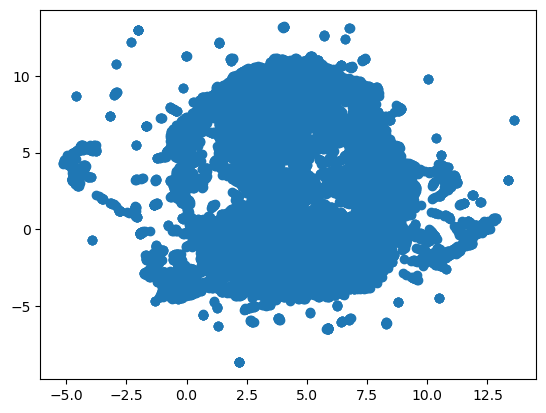

In [14]:
plt.scatter(umap_df['x'], umap_df['y'])

In [15]:
data = avg_df[list(avg_df.columns)[1:]].values

random_state = 42
n_components = 2
n_neighbors = 3
embedding_metric = 'manhattan'

umap_mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors, metric=embedding_metric).fit(data)
embedding = bokeh_ui_utils._get_umap_embedding(umap_mapper)

avg_umap_df = pd.DataFrame(np.array(embedding), columns=('x', 'y'))

avg_umap_df['label'] = avg_df['label'].values

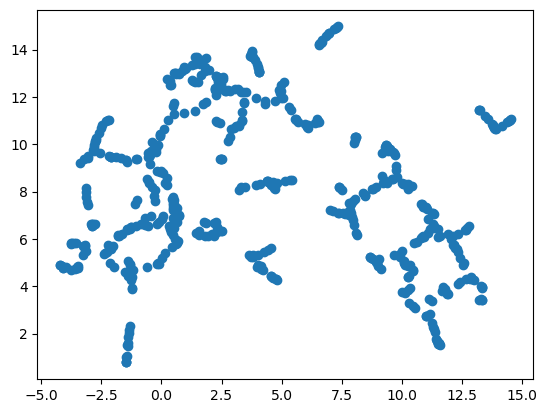

In [16]:
plt.scatter(avg_umap_df['x'], avg_umap_df['y'])

In [17]:
mds_mapper = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', random_state=42)
embedding = mds_mapper.fit_transform(clustering_utils.compute_pairwise_distance_matrix(avg_df, 'manhattan'))

avg_mds_df = pd.DataFrame(np.array(embedding), columns=('x', 'y'))

avg_mds_df['label'] = avg_df['label'].values

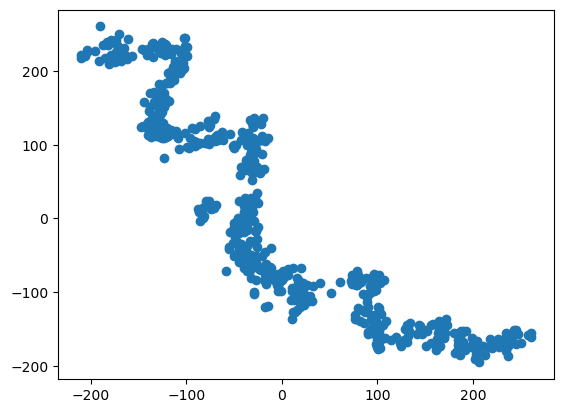

In [18]:
plt.scatter(avg_mds_df['x'], avg_mds_df['y'])

In [19]:
nmds_mapper = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', metric=False, random_state=42)
embedding = nmds_mapper.fit_transform(clustering_utils.compute_pairwise_distance_matrix(avg_df, 'manhattan'))

avg_nmds_df = pd.DataFrame(np.array(embedding), columns=('x', 'y'))

avg_nmds_df['label'] = avg_df['label'].values

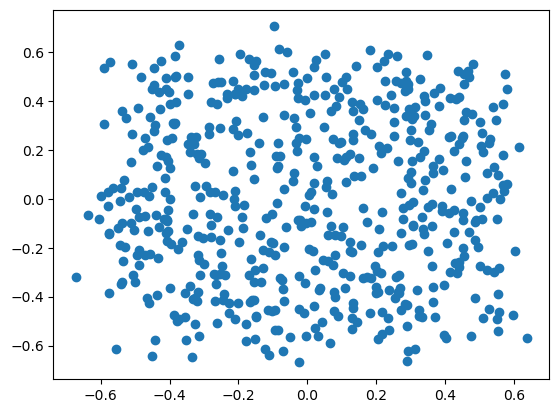

In [20]:
plt.scatter(avg_nmds_df['x'], avg_nmds_df['y'])

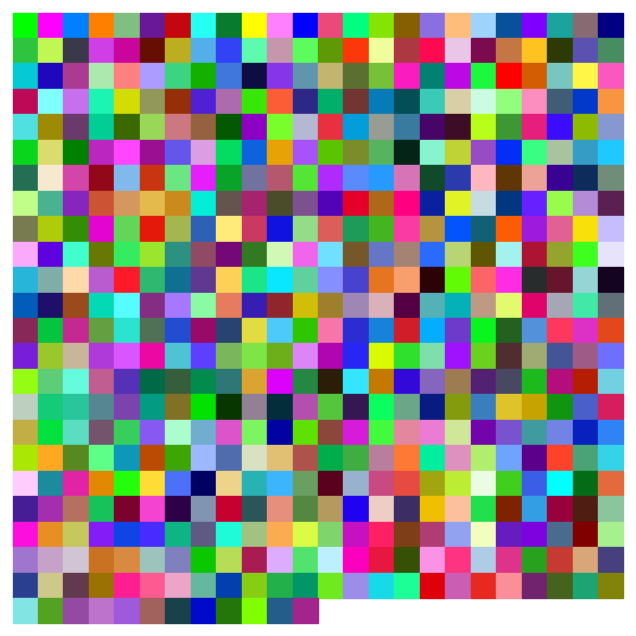

In [21]:
num_colors = len(umap_df['label'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)
colors_dict = {m : rgb_to_hex(colors[idx]) for idx, m in enumerate(umap_df['label'].unique())}

In [22]:
plots = [
generate_embedding_plot(umap_df, colors_dict, title=f'{DATASET}_umap_df'),
generate_embedding_plot(avg_umap_df, colors_dict, title=f'{DATASET}_avg_umap_df'),
generate_embedding_plot(mds_embeddind_df, colors_dict, title=f'{DATASET}_mds_embeddind_df'),
generate_embedding_plot(nmds_embeddind_df, colors_dict, title=f'{DATASET}_nmds_embeddind_df'),
generate_embedding_plot(avg_mds_df, colors_dict, title=f'{DATASET}_avg_mds_df'),
generate_embedding_plot(avg_nmds_df, colors_dict, title=f'{DATASET}_avg_nmds_df'),
]

In [23]:
tabs = [TabPanel(child=p, title=p.title.text) for p in plots]

tabbed_plot = Tabs(tabs=tabs, sizing_mode='stretch_both')

output_file(f'./{DATASET}_embedding_comparison.html')

save(tabbed_plot)

'/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/microarray_embedding_comparison.html'